In [1]:
#Gp with rescaled gamma prior

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.spatial
from mpl_toolkits.mplot3d import Axes3D
import pylab 
import math
import time

In [3]:
# %matplotlib inline
np.random.seed(42)

In [4]:
def swill_roll_f4(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15)

def swill_roll_non_embed_f(n_data = 200, noise_add = True, sigma_noise = 0.1, f = None):
    swiss_roll = np.zeros((3, n_data))
    U = np.random.uniform(low=2*np.pi/2,high = 9*np.pi/2, size= n_data)
    V = np.random.uniform(low=0,high = 15, size= n_data)
    swiss_roll[0,:] = U * np.cos(U)
    swiss_roll[1,:] = V
    swiss_roll[2,:] =  U*np.sin(U)
    Y = f(U,V)
    Y_noise = Y.copy()
    if noise_add:
        Y_noise +=  np.random.randn(n_data) * sigma_noise

    swiss_roll_embed =swiss_roll
    return swiss_roll_embed.T, Y, Y_noise

def swill_roll_curve_non_embed_f(n_data = 200, noise_add = True, sigma_noise = 0.1, p = 0.5, f = None):
    swiss_roll = np.zeros((3, n_data))
    n_swiss = np.random.binomial(n_data, p)
    U = np.random.uniform(low=2*np.pi/2,high = 9*np.pi/2, size= n_swiss)
    V = np.random.uniform(low=0,high = 15, size= n_swiss)

    swiss_roll[0,:n_swiss] = U * np.cos(U)
    swiss_roll[1,:n_swiss] = V
    swiss_roll[2,:n_swiss] =  U*np.sin(U)
    t = np.random.uniform(low= -1,high = 1, size=  n_data - n_swiss)
    swiss_roll[0,n_swiss:] = 7*np.pi/2 *np.cos(np.pi * t) * np.cos(4 * np.pi * t)
    swiss_roll[1,n_swiss:] = 7*np.pi/2 + 7*np.pi/2 *np.cos(np.pi * t) * np.sin(4 * np.pi * t)
    swiss_roll[2,n_swiss:] = 7*np.pi/2 *np.sin(np.pi * t)
    U_1 = np.sqrt(swiss_roll[0,n_swiss:] ** 2 + swiss_roll[2,n_swiss:] ** 2)
    V_1 = swiss_roll[1,n_swiss:]
    Y = np.zeros(n_data)
    Y[:n_swiss] = f(U,V)
    Y[n_swiss:] = f(U_1,V_1)
    Y_noise = Y.copy()
    if noise_add:
        Y_noise +=  np.random.randn(n_data) * sigma_noise
    swiss_roll_embed =swiss_roll
    return swiss_roll_embed.T, Y, Y_noise


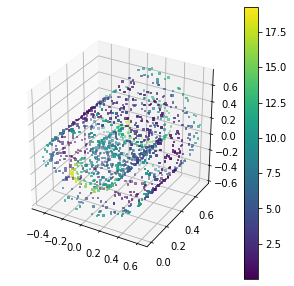

In [5]:
# visualizing a dataset
    
X, Y_true, Y_noise = swill_roll_non_embed_f(n_data = 1200, f = swill_roll_f4)

#change this line to switch to mixed dimension example
#X, Y_true, Y_noise = swill_roll_curve_non_embed_f(n_data = 1200, f = swill_roll_f4)

dig_len= np.max(np.sum(X**2, axis = 1))
X = X / np.sqrt(dig_len)
x = X[:,0]
y = X[:,1]
z_1 = X[:,2]
colo = Y_true

# creating figures
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
  
# setting color bar
color_map = pylab.cm.ScalarMappable()
color_map.set_array(colo)
  
img = ax.scatter(x, y, z_1, marker='s',
                 s=2, c= colo)
plt.colorbar(color_map)
  

ax.set_box_aspect([1,1,1])
# displaying plot
plt.show()
#plt.savefig('/Users/tt/Desktop/Git Codes/Research/Gp:Kernel Regression on Unknown Manifold/Figures/swiss_roll_true_3d')

In [6]:
# If want to reproduce results in the paper, change to next line
#data_number = [50,100,200,400,800, 1600]
data_number = [50,100,200]
N_num = len(data_number)
dict_num = {num:i for i, num in enumerate(data_number)}

sigmasq_0 = 0.01
replicas = 5


#MCMC params
mcmc_time = 3000
burn_in = 1000

In [7]:
#Herustic to choose MCMC parameter sigma_proposal_knn
#grid to select proposal
n_grid = 100
ls_grid_epsilon = np.linspace(10**-6, 0.2, n_grid)
log_grid_likelihoods = np.zeros(n_grid)
log_grid_pos = np.zeros(n_grid)
grid_pos_tolerance = 10**(-8)
std_proposals = {}
start_points = {}
for train_size in data_number:
    test_size = 0
    n_data = train_size + test_size
    
    #change this line to switch to mixed dimension example
    #X, Y_de, Y = swill_roll_curve_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
    X, Y_de, Y = swill_roll_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
    
    dig_len= np.max(np.sum(X**2, axis = 1))
    X = X / np.sqrt(dig_len)  
    
    idx = np.arange(n_data)
    np.random.shuffle(idx)
    train_idx, test_idx = idx[:train_size], idx[train_size:]
    X_train, X_test = X[train_idx], X[test_idx]
    Y_de_train, Y_de_test = Y_de[train_idx], Y_de[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
    dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
    dists_XX_sq = dists_XX**2
    dists_pX_sq = dists_pX**2

    #Compute kernel for different bandwidth  
    for i, epsilon in enumerate(ls_grid_epsilon):
        k_XX_de =  np.exp(-0.5 * dists_XX_sq/epsilon)
        k_pX =  np.exp(-0.5 * dists_pX_sq/epsilon)
        k_XX = np.copy(k_XX_de)
        k_XX = k_XX + np.eye(train_size) *sigmasq_0
        
        hat_inverse = np.linalg.solve(k_XX, Y_train)
        log_grid_likelihoods[i] = -0.5 * np.matmul(Y_train, hat_inverse)
        log_grid_likelihoods[i] += -0.5 * np.linalg.slogdet(k_XX)[1]
        log_grid_pos[i] = log_grid_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon

    weight_pos = np.exp(log_grid_pos - np.max(log_grid_pos))
    weight_pos = weight_pos/np.sum(weight_pos)
    pos_grid_maxp = ls_grid_epsilon[np.argmax(weight_pos)]
    
    ls_grid_select=ls_grid_epsilon[weight_pos>grid_pos_tolerance]
    sigma_proposal =(max(ls_grid_select) - min(ls_grid_select))/25
    print(sigma_proposal)
    
    sigma_proposal = np.round(sigma_proposal * 1000)/1000
    std_proposals[train_size] = sigma_proposal
    start_points[train_size] = pos_grid_maxp

0.0009696921212121215
0.001050499797979798
0.0008080767676767678


In [8]:
std_proposals

{50: 0.001, 100: 0.001, 200: 0.001}

In [9]:
start_points

{50: 0.052525989898989905, 100: 0.050505797979797984, 200: 0.05656637373737374}

In [10]:
w_pos_means, w_pos_std =np.zeros(N_num), np.zeros(N_num)
w_pos_test_means, w_pos_test_std=np.zeros(N_num), np.zeros(N_num)
test_size = 2000
for train_size in data_number:
    n_data = train_size + test_size

    ls_w_pos = np.zeros(replicas)
    ls_w_pos_test = np.zeros(replicas)

    for replica in range(replicas):
        start = time.time()
        
        #change this line to switch to mixed dimension example
        #X, Y_de, Y = swill_roll_curve_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
        X, Y_de, Y = swill_roll_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
        
        dig_len= np.max(np.sum(X**2, axis = 1))
        X = X / np.sqrt(dig_len)  

        idx = np.arange(n_data)
        np.random.shuffle(idx)
        train_idx, test_idx = idx[:train_size], idx[train_size:]
        X_train, X_test = X[train_idx], X[test_idx]
        Y_de_train, Y_de_test = Y_de[train_idx], Y_de[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        #Record pairwise distance and square
        dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
        dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
        dists_XX_sq = dists_XX**2
        dists_pX_sq = dists_pX**2
        

        #MCMC
        ls_epsilon = np.zeros(mcmc_time)
        ls_epsilon[0] = start_points[train_size]
        Y_pred_train = np.zeros((mcmc_time,train_size))
        Y_pred_test = np.zeros((mcmc_time,test_size))
        sigma_proposal = std_proposals[train_size] 
        
        log_likelihoods = np.zeros(mcmc_time)
        log_pos = np.zeros(mcmc_time)
        for i in range(1, mcmc_time):  
            #gaussian proposal
            epsilon = max(np.random.randn(1)*sigma_proposal + ls_epsilon[i-1],0)

            k_XX_de =  np.exp(-0.5 * dists_XX_sq/epsilon)
            k_pX =  np.exp(-0.5 * dists_pX_sq/epsilon)
            k_XX = np.copy(k_XX_de)
            k_XX = k_XX + np.eye(train_size) *sigmasq_0
    
            
            hat_inverse = np.linalg.solve(k_XX, Y_train)
            log_likelihoods[i] = -0.5 * np.matmul(Y_train, hat_inverse)
            log_likelihoods[i] += -0.5 * np.linalg.slogdet(k_XX)[1]
            
            log_pos[i] = log_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon #rescaled gamma posterior in paper
            #Metropolis Hasting
            log_pos_raio = min(0., log_pos[i] - log_pos[i-1])
            accept_flag = np.log(np.random.uniform(0,1)) <= log_pos_raio
            if accept_flag:
                ls_epsilon[i] = epsilon
                Y_pred_train[i,:] = np.matmul(k_XX_de, hat_inverse)
                Y_pred_test[i,:] = np.matmul(k_pX, hat_inverse)
            else:
                ls_epsilon[i] = ls_epsilon[i-1]
                Y_pred_train[i,:] = Y_pred_train[i-1,:]
                Y_pred_test[i,:] = Y_pred_test[i-1,:]
        err_in = np.sqrt(np.mean((Y_de_train - np.mean(Y_pred_train[burn_in:], axis = 0))**2))
        err_te = np.sqrt(np.mean((Y_de_test - np.mean(Y_pred_test[burn_in:], axis = 0))**2))
        ls_w_pos[replica] = err_in
        ls_w_pos_test[replica] = err_te

        print("rescaled prior: ",f"IS error: {err_in:.2f}", f"IS error: {err_te:.2f}")
        print(f"{replica+1} replica time: {(time.time() - start):2f}")
        
    w_pos_means[dict_num[train_size]] = np.mean(ls_w_pos)
    w_pos_std[dict_num[train_size]] = np.std(ls_w_pos)
    w_pos_test_means[dict_num[train_size]] =  np.mean(ls_w_pos_test)
    w_pos_test_std[dict_num[train_size]] = np.std(ls_w_pos_test)
    
    print('rescaled prior: ',f"IS mean: {w_pos_means[dict_num[train_size]]:.2f}", f"IS std: {w_pos_std[dict_num[train_size]]:.2f}",f"OS mean: {w_pos_test_means[dict_num[train_size]]:.2f}",f"OS std: {w_pos_test_std[dict_num[train_size]]:.2f}")

rescaled prior:  IS error: 0.14 IS error: 2.70
1 replica time: 2.709896
rescaled prior:  IS error: 0.18 IS error: 2.41
2 replica time: 3.112723
rescaled prior:  IS error: 0.18 IS error: 2.42
3 replica time: 3.300167
rescaled prior:  IS error: 0.14 IS error: 2.23
4 replica time: 3.229109
rescaled prior:  IS error: 0.13 IS error: 2.17
5 replica time: 4.000523
rescaled prior:  IS mean: 0.15 IS std: 0.02 OS mean: 2.39 OS std: 0.19
rescaled prior:  IS error: 0.15 IS error: 1.24
1 replica time: 8.315383
rescaled prior:  IS error: 0.15 IS error: 1.36
2 replica time: 7.700059
rescaled prior:  IS error: 0.14 IS error: 1.10
3 replica time: 7.449306
rescaled prior:  IS error: 0.17 IS error: 1.21
4 replica time: 8.342393
rescaled prior:  IS error: 0.16 IS error: 1.06
5 replica time: 11.161802
rescaled prior:  IS mean: 0.15 IS std: 0.01 OS mean: 1.19 OS std: 0.11
rescaled prior:  IS error: 0.12 IS error: 0.71
1 replica time: 20.831985
rescaled prior:  IS error: 0.14 IS error: 0.51
2 replica time: 1

In [11]:
print(w_pos_means)
print(w_pos_std)
print(w_pos_test_means)
print(w_pos_test_std)

[0.15434817 0.1514814  0.1345254 ]
[0.02143603 0.01092575 0.00527388]
[2.38694817 1.19455203 0.65023719]
[0.18551206 0.108645   0.07359364]


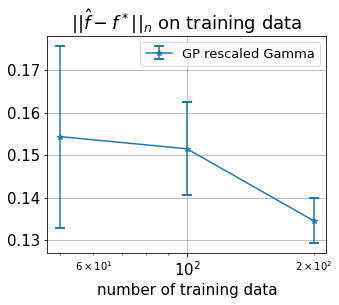

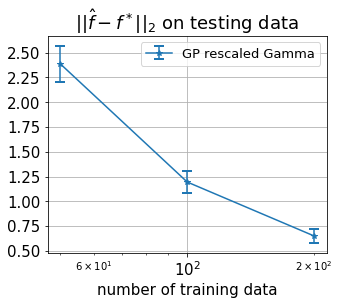

In [12]:
#In-sample error
plt.figure(figsize=(5,4))

plt.errorbar(data_number, w_pos_means, w_pos_std, linestyle='-', marker='*',label = "GP rescaled Gamma",capsize=5, capthick=2)
plt.xscale('log')
plt.xlabel('number of training data', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize=13)
plt.title(r'$||\hat{f}-f^*||_{n}$ on training data', fontsize = 18)

#Out-of-sample error 
plt.figure(figsize=(5,4))
plt.errorbar(data_number, w_pos_test_means, w_pos_test_std, linestyle='-', marker='*',label = "GP rescaled Gamma",capsize=5, capthick=2)
plt.xlabel('number of training data', fontsize = 15)
plt.grid()
plt.title(r'$||\hat{f}-f^*||_{2}$ on testing data', fontsize = 18)
plt.xscale('log')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize=13)
plt.show()